# LSST DM Stack Image Quality Walkthrough

Author: Keith Bechtol

Last edited: 2018-07-05

Works on DM Stack release: Weekly `2018_28` 

You can find the Stack version by using `eups list -s` on the terminal command line.

This notebook provides a walkthrough of several image quality measurements in the LSST DM Stack. The walk-through is based on the following resources, which should be consulted for further details:

* _The Hyper Suprime-Cam Software Pipeline_: https://arxiv.org/abs/1705.06766
* _The first-year shear catalog of the Subaru Hyper-Suprime-Cam SSP Survey_: https://arxiv.org/abs/1705.06745
* Systematics Tests In LEnsing (STILE): https://github.com/msimet/Stile

In [1]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

jld-lab-kbechtol-w201830
lsst_distrib          16.0+19    	current w_2018_30 setup


In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Prelude: Data Sample

Begin by identifying a data sample to use for illustration. In this example, we will use a recent reprocessing of the HSC SSP DR1.

Information available here: https://confluence.lsstcorp.org/display/DM/S18+HSC+PDR1+reprocessing

The output repos are:
* /datasets/hsc/repo/rerun/DM-13666/UDEEP/
* /datasets/hsc/repo/rerun/DM-13666/DEEP/
* /datasets/hsc/repo/rerun/DM-13666/WIDE/

Note that each of the data repositories contains all of the HSC visits, so one has to select by field to get the visits corresponding to a particular Strategic Survey Program (SSP) survey.

In [3]:
import lsst.daf.persistence as daf_persistence

In [4]:
# Instantiate the butler
band = 'HSC-I'
depth = 'WIDE' # WIDE, DEEP, UDEEP
field = 'SSP_WIDE' # SSP_WIDE, SSP_DEEP, SSP_UDEEP
butler = daf_persistence.Butler('/datasets/hsc/repo/rerun/DM-13666/%s/'%(depth))

In [5]:
# Obtain a random dataid for a single-CCD image in the i-band
subset = butler.subset('calexp', dataId={'filter':band, 'field':field})
dataid = subset.cache[0]
print(dataid)

{'filter': 'HSC-I', 'field': 'SSP_WIDE', 'pointing': 1318, 'visit': 38056, 'ccd': 27, 'dateObs': '2015-08-11', 'taiObs': '2015-08-11', 'expTime': 200.0}


In [6]:
# Use that dataid to get the image and associated source catalog
calexp = butler.get('calexp', **dataid)
src = butler.get('src', **dataid)

# Note that the calexp contains a PSF object
psf = calexp.getPsf()

## Part 1: PSF Model

In [7]:
shape = psf.computeShape()

### PSF Size

This walkthrough focuses on the computation of PSF models and shape measurements using adaptive moments. Two common methods of computing the PSF size from adaptive moments are the trace radius and determinant radius.

Adaptive second moments:

$Q = \begin{bmatrix}
    I_{xx} & I_{xy} \\
    I_{xy} & I_{yy}
  \end{bmatrix}$
  
The trace radius is defined as $\rm{Tr}(Q) = \sqrt{\frac{I_{xx} + I_{yy}}{2}}$ and determinant radius is defined as $\rm{Det(Q)} = (I_{xx} I_{yy} - I_{xy}I_{xy})^\frac{1}{4}$

In [8]:
i_xx, i_yy, i_xy = shape.getIxx(), shape.getIyy(), shape.getIxy()

Put in a few assert statements to show exactly what the Stack is doing

In [9]:
# Trace radius
assert np.isclose(shape.getTraceRadius(), np.sqrt((i_xx + i_yy) / 2.))
print('trace radius =', shape.getTraceRadius())

trace radius = 1.1731632972713912


In [10]:
# Determinant radius
assert np.isclose(shape.getDeterminantRadius(), (i_xx * i_yy - i_xy**2)**(1. / 4.))
print('determinant radius =', shape.getDeterminantRadius())

determinant radius = 1.173018575283528


### Comment Regarding Units

What are the units of the trace radius and determinant radius? How do we convert the trace radius or determinant radius into FWHM in arcseconds? To do this, we need to quickly preview some functionality available from the calibrated image and source catalog.

First, let's make sure that the PSF shape second moments from the PSF model in the calibrated exposure (calexp) match the entry for the source catalog for the PSF at the source position.

In [11]:
from lsst.afw.geom import Point2D

# PSF shape at coordinates of first indexed souce
shape = psf.computeShape(Point2D(src['slot_Centroid_x'][0], src['slot_Centroid_y'][0])) 
print(shape.getIxx())
# Compare to catalog entry for PSF shape
print(src['slot_PsfShape_xx'][0])

1.391864440986452
1.3925510597907107


In [12]:
# Pixel scale in arcseconds
calexp.getWcs().getPixelScale().asArcseconds()

0.16562385882475927

In [13]:
# Units of the second moments
#src.schema.find('base_SdssShape_psf_xx').getField().getUnits()
src.schema.find('slot_PsfShape_xx').getField().getUnits()

'pixel^2'

We find that the trace radius and determinant radius are in units of pixels, and we found the pixel scale in arcseconds

For a one-dimensional gaussian, the FWHM = $2 \sqrt{2 \ln 2}$ RMS = 2.35 RMS 

**THIS APPROXIMATION FOR THE FWHM SHOULD BE VERIFIED**

In [14]:
# Approximate FWHM in arcseconds
fwhm = 2 * np.sqrt(2. * np.log(2)) * shape.getTraceRadius() * calexp.getWcs().getPixelScale().asArcseconds()
print('FWHM = %.3f arcsec'%(fwhm))

FWHM = 0.469 arcsec


### PSF Ellipticity

**IMPORTANT:** Two conventions are commonly used in weak gravitational lensing to define ellipticity. The LSST Stack uses the 
"distortion" convention as oppose to the "shear" convention. See https://en.wikipedia.org/wiki/Gravitational_lensing_formalism#Measures_of_ellipticity for both definitions.

The Science Requirements Document (https://docushare.lsst.org/docushare/dsweb/Get/LPM-17) also uses the distortion convention.

Formalism ellipticities in the distortion convention:

$e_1 = \frac{I_{xx} - I_{yy}}{I_{xx} + I_{yy}}$

$e_2 = \frac{2 I_{xy}}{I_{xx} + I_{yy}}$

$\tan(2 \theta) = \frac{2 I_{xy}}{I_{xx} - I_{yy}} $

Put in a few assert statements to explicitly show what the Stack is doing

In [15]:
# Ellipticity
from lsst.afw.geom.ellipses import Quadrupole, SeparableDistortionTraceRadius

q = Quadrupole(i_xx, i_yy, i_xy)
s = SeparableDistortionTraceRadius(q)
assert np.isclose(s.getE1(), (i_xx - i_yy) / (i_xx + i_yy)) # e1
print('e1 =', s.getE1())
assert np.isclose(s.getE2(), (2. * i_xy) / (i_xx + i_yy)) # e2
print('e2 =', s.getE2())
assert np.isclose(s.getEllipticity().getTheta(), np.arctan2(2. * i_xy, i_xx - i_yy) / 2.) # theta
print('theta =', s.getEllipticity().getTheta())

# An alternative way to compute the angle
e1, e2 = s.getE1(), s.getE2() 
assert np.allclose(np.arctan2(e2, e1) / 2., np.arctan2(2. * i_xy, i_xx - i_yy) / 2.)

e1 = -0.01283363818748362
e2 = 0.018128661088852256
theta = 1.09340892116512


For visualization purposes, let's evaluate the PSF model at grid of points across the image

In [16]:
n = 100
x_array = np.arange(0, calexp.getDimensions()[0], 200)
y_array = np.arange(0, calexp.getDimensions()[1], 200)
xx, yy = np.meshgrid(x_array, y_array)

print(calexp.getDimensions())

size = []
i_xx = []
i_yy = []
i_xy = []
for x, y in zip(xx.flatten(), yy.flatten()):
    point = Point2D(x, y)
    shape = psf.computeShape(point)
    size.append(shape.getTraceRadius())
    i_xx.append(shape.getIxx())
    i_yy.append(shape.getIyy())
    i_xy.append(shape.getIxy())
size = np.reshape(size, xx.shape)
i_xx = np.reshape(i_xx, xx.shape)
i_yy = np.reshape(i_yy, xx.shape)
i_xy = np.reshape(i_xy, xx.shape)

theta = np.arctan2(2. * i_xy, i_xx - i_yy) / 2.
e1 = (i_xx - i_yy) / (i_xx + i_yy)
e2 = (2. * i_xy) / (i_xx + i_yy)
theta_alternate = np.arctan2(e2, e1) / 2.
assert np.allclose(theta, theta_alternate)
e = np.sqrt(e1**2 + e2**2)
ex = e * np.cos(theta)
ey = e * np.sin(theta)

(2048, 4176)


and then plot the results in a few different ways

Text(0,0.5,'y')

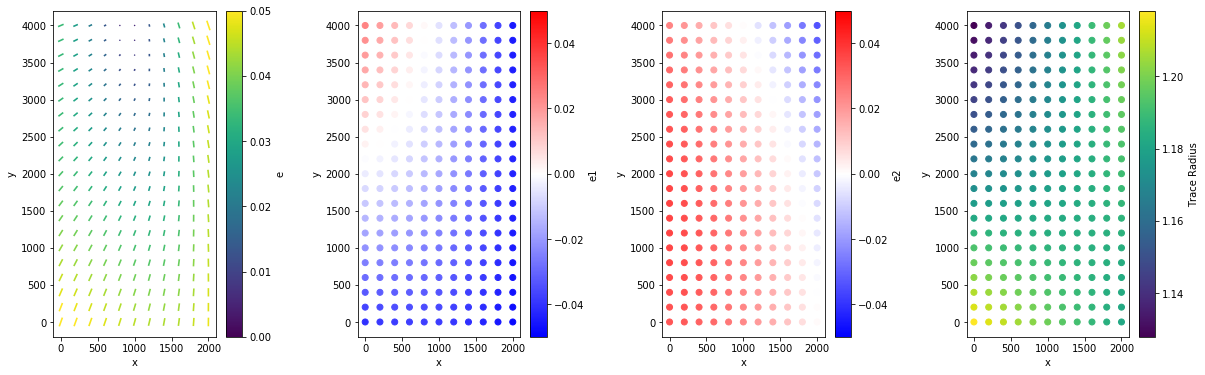

In [17]:
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 4, 1)
plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.01)
#plt.quiver(xx, yy, scale=e, angles=phi, headlength=0., headwidth=1., pivot='mid', width=0.005)
#colorbar = plt.colorbar(label='r$\sqrt(e1^{2} + e2^{2})$')
colorbar = plt.colorbar(label='e')
plt.clim(0., 0.05)
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 4, 2)
plt.scatter(xx, yy, c=e1, vmin=-0.05, vmax=0.05, cmap='bwr')
colorbar = plt.colorbar(label='e1')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 4, 3)
plt.scatter(xx, yy, c=e2, vmin=-0.05, vmax=0.05, cmap='bwr')
colorbar = plt.colorbar(label='e2')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 4, 4)
plt.scatter(xx, yy, c=size)
colorbar = plt.colorbar(label='Trace Radius')
plt.xlabel('x')
plt.ylabel('y')

## Part 2: Source Catalog Shape Measurements

The source catalogs include many measurements of source shapes and PSF model shapes

In [18]:
# I'm still learning how to use regular expressions...
#import re
#list(filter(re.compile(".*shape*"), src.schema.getOrderedNames()))

In [19]:
# Columns for shape measurements
for name in src.schema.getOrderedNames():
    if 'shape' in name.lower():
        print(name)

base_Blendedness_flag_noShape
base_SdssShape_xx
base_SdssShape_yy
base_SdssShape_xy
base_SdssShape_xxSigma
base_SdssShape_yySigma
base_SdssShape_xySigma
base_SdssShape_x
base_SdssShape_y
base_SdssShape_flux
base_SdssShape_fluxSigma
base_SdssShape_psf_xx
base_SdssShape_psf_yy
base_SdssShape_psf_xy
base_SdssShape_flux_xx_Cov
base_SdssShape_flux_yy_Cov
base_SdssShape_flux_xy_Cov
base_SdssShape_flag
base_SdssShape_flag_unweightedBad
base_SdssShape_flag_unweighted
base_SdssShape_flag_shift
base_SdssShape_flag_maxIter
base_SdssShape_flag_psf
ext_shapeHSM_HsmPsfMoments_x
ext_shapeHSM_HsmPsfMoments_y
ext_shapeHSM_HsmPsfMoments_xx
ext_shapeHSM_HsmPsfMoments_yy
ext_shapeHSM_HsmPsfMoments_xy
ext_shapeHSM_HsmPsfMoments_flag
ext_shapeHSM_HsmPsfMoments_flag_no_pixels
ext_shapeHSM_HsmPsfMoments_flag_not_contained
ext_shapeHSM_HsmPsfMoments_flag_parent_source
ext_shapeHSM_HsmShapeRegauss_e1
ext_shapeHSM_HsmShapeRegauss_e2
ext_shapeHSM_HsmShapeRegauss_sigma
ext_shapeHSM_HsmShapeRegauss_resolution
ext_s

Columns for calibration measurements, including indicators of the stars using for PSF modeling and held in reserve for testing the PSF model.

In [20]:
# Columns for calibration measurements
for name in src.schema.getOrderedNames():
    if 'calib' in name.lower():
        print(name)

calib_detected
calib_psfCandidate
calib_psfUsed
calib_psf_reserved
calib_astrometryUsed
calib_photometry_used
calib_photometry_reserved


There are also "slots" defined for default measurements

In [21]:
# How are the slots defined?
for slot in ['slot_PsfShape', 'slot_Shape']:
    print('%s -> %s'%(slot, src.schema.getAliasMap()[slot]))

slot_PsfShape -> ext_shapeHSM_HsmPsfMoments
slot_Shape -> ext_shapeHSM_HsmSourceMoments


To figure out what these columns mean, look at https://arxiv.org/abs/1705.06745

**Non PSF-corrected shapes**

SDSS algorithm:

`base_SdssShape_xx/xy/yy` = Adaptive moments in arcsec$^2$, SDSS algorithm

`base_SdssShape_psf_xx/xy/yy` = Adaptive moments of PSF evaluated at object position in arcsec$^2$, SDSS algorithm

HSM algorithm: 

_Galaxy shapes are estimated on the coadded i-band images using the re-Gaussianization PSF correction method (Hirata & Seljak 2003)... In the course of the re-Gaussianization PSF-correction method, corrections are applied to account for dilution of the observed shape by the PSF, including the non-Gaussianity of both the PSF and the galaxy surface brightness profiles._

`ext_shapeHSM_HsmPsfMoments_xx/xy/yy` = Adaptive moments of PSF evaluated at object position in arcsec$^2$, HSM algorithm

`ext_shapeHSM_HsmSourceMoments_xx/xy/yy` = Adaptive moments in arcsec$^2$, not PSF-corrected , HSM algorithm

`ext_shapeHSM_HsmSourceMomentsRound_xx/xy/yy` = ??

**Regaussianization shapes based on data alone, PSF-corrected**

`ext_shapeHSM_HsmShapeRegauss_e1/e2` = distortion in sky coordinates estimated by regaussianization method defined in distortion, HSM algorithm (**NEED TO CHECK IF THESE ARE SKY OR INSTRUMENT COORDINATES**)

`ext_shapeHSM_HsmShapeRegauss_sigma` = non-calibrated shape measurement noise, HSM algorithm

`ext_shapeHSM_HsmShapeRegauss_resolution` = resolution of galaxy image defined in equation (4) of https://arxiv.org/abs/1705.06745, HSM algorithm

With those definitions in mind, now verify that the PSF models from SDSS and HSM algorithms are consistent by comparing adaptive moments of the PSF. The plot below shows the ratio of adaptive moment sizes is very nearly unity. The plot also shows no trend in adaptive moments with respect to how well the source is resolved (i.e., source size), which is as expected since we are comparing PSF models as oppose to measurements for individual sources.

Text(0,0.5,'base_SdssShape_psf / ext_shapeHSM_HsmPsfMoments')

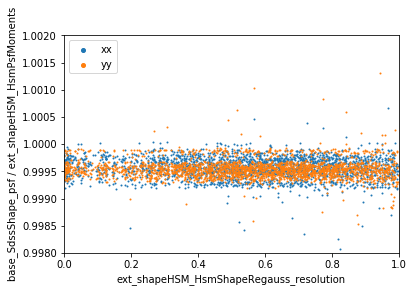

In [22]:
plt.figure()
plt.scatter(src['ext_shapeHSM_HsmShapeRegauss_resolution'], 
            src['base_SdssShape_psf_xx'] / src['ext_shapeHSM_HsmPsfMoments_xx'], s=1, label='xx')
plt.scatter(src['ext_shapeHSM_HsmShapeRegauss_resolution'], 
            src['base_SdssShape_psf_yy'] / src['ext_shapeHSM_HsmPsfMoments_yy'], s=1, label='yy')
plt.xlim(0., 1.)
plt.ylim(1. - 2.e-3, 1. + 2.e-3)
plt.legend(loc='upper left', markerscale=4)
plt.xlabel('ext_shapeHSM_HsmShapeRegauss_resolution')
plt.ylabel('base_SdssShape_psf / ext_shapeHSM_HsmPsfMoments')

To illustrate the difference between the PSF-corrected and non-PSF-corrected quantities within the HSM algorithm, now compare the ellipticity computed from the adaptive moments (not-PSF corrected) with the ellipticity including PSF-corrections. In the plot below, we see a clear trend with the amount of source resolution. For sources that are increasingly resolved, the PSF-corrected and non-PSF-corrected ellipticities converge. For sources that are not well resolved, the PSF-corrected and non-PSF-corrected ellipticities diverge.

Text(0,0.5,'HsmSourceMoments_e1 / HsmShapeRegauss_e1')

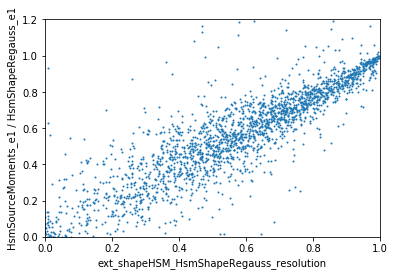

In [23]:
i_xx, i_yy, i_xy = src['ext_shapeHSM_HsmSourceMoments_xx'], src['ext_shapeHSM_HsmSourceMoments_yy'], src['ext_shapeHSM_HsmSourceMoments_xy']
e1_non_psf_corrected = (i_xx - i_yy) / (i_xx + i_yy)
ratio = e1_non_psf_corrected / src['ext_shapeHSM_HsmShapeRegauss_e1']
#trace_radius = np.sqrt((src['base_SdssShape_xx'] + src['base_SdssShape_yy']) / 2.)

plt.figure()
plt.scatter(src['ext_shapeHSM_HsmShapeRegauss_resolution'], ratio, s=1)
plt.xlim(0., 1.)
plt.ylim(0., 1.2)
plt.xlabel('ext_shapeHSM_HsmShapeRegauss_resolution')
plt.ylabel('HsmSourceMoments_e1 / HsmShapeRegauss_e1')

## Intermission

In the next section of the notebook, we'll use a full tract worth of data for some of the examples. It will take about 10 minutes to ingest the object catalogs from each patch in the tract. If you don't want to wait, set the SHORTCUT variable below to True.

In [24]:
import pandas as pd

/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-10a4fa6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [25]:
# Browse the deepCoadd_meas schema
dataid = {'filter':'HSC-I', 'tract':9936, 'patch':'0,0'}
coadd_meas = butler.get('deepCoadd_meas', dataId=dataid)
#coadd_meas.schema
#coadd_meas['slot_ModelFlux_fluxSigma']

In [26]:
# Set SHORTCUT = True for quick evaluation but lower statistics
SHORTCUT = False

skymap = butler.get('deepCoadd_skyMap')

# Pick a random tract and collect all the patches
tract = 9936
patch_array = []
for ii in range(skymap.generateTract(tract).getNumPatches()[0]):
    for jj in range(skymap.generateTract(tract).getNumPatches()[1]):
        patch_array.append('%s,%s'%(ii, jj))
tract_array = np.tile(tract, len(patch_array))

if SHORTCUT:
    # Only get three patches
    df_tract_patch = pd.DataFrame({'tract': [9936, 9936, 9936],
                                   'patch': ['0,0', '0,1', '0,2']})
else:
    # Get all the object catalogs from one tract
    df_tract_patch = pd.DataFrame({'tract': tract_array,
                                   'patch': patch_array})

In [27]:
selected_columns = ['id',
                    'coord_ra', 
                    'coord_dec',
                    'base_SdssCentroid_x',
                    'base_SdssCentroid_y',
                    'calib_psfCandidate',
                    'calib_psfUsed',
                    'base_ClassificationExtendedness_value',
                    'base_ClassificationExtendedness_flag',
                    'ext_shapeHSM_HsmPsfMoments_x',
                    'ext_shapeHSM_HsmPsfMoments_y',
                    'ext_shapeHSM_HsmPsfMoments_xx',
                    'ext_shapeHSM_HsmPsfMoments_yy',
                    'ext_shapeHSM_HsmPsfMoments_xy',
                    'ext_shapeHSM_HsmPsfMoments_flag',
                    'ext_shapeHSM_HsmPsfMoments_flag_no_pixels',
                    'ext_shapeHSM_HsmPsfMoments_flag_not_contained',
                    'ext_shapeHSM_HsmPsfMoments_flag_parent_source',
                    'ext_shapeHSM_HsmShapeRegauss_e1',
                    'ext_shapeHSM_HsmShapeRegauss_e2',
                    'ext_shapeHSM_HsmShapeRegauss_sigma',
                    'ext_shapeHSM_HsmShapeRegauss_resolution',
                    'ext_shapeHSM_HsmShapeRegauss_flag',
                    'ext_shapeHSM_HsmShapeRegauss_flag_no_pixels',
                    'ext_shapeHSM_HsmShapeRegauss_flag_not_contained',
                    'ext_shapeHSM_HsmShapeRegauss_flag_parent_source',
                    'ext_shapeHSM_HsmShapeRegauss_flag_galsim',
                    'ext_shapeHSM_HsmSourceMoments_x',
                    'ext_shapeHSM_HsmSourceMoments_y',
                    'ext_shapeHSM_HsmSourceMoments_xx',
                    'ext_shapeHSM_HsmSourceMoments_yy',
                    'ext_shapeHSM_HsmSourceMoments_xy',
                    'ext_shapeHSM_HsmSourceMoments_flag',
                    'ext_shapeHSM_HsmSourceMoments_flag_no_pixels',
                    'ext_shapeHSM_HsmSourceMoments_flag_not_contained',
                    'ext_shapeHSM_HsmSourceMoments_flag_parent_source',
                    'slot_Centroid_x',
                    'slot_Centroid_y',
                    'slot_Shape_xx',
                    'slot_Shape_yy',
                    'slot_Shape_xy',
                    'slot_PsfShape_xx',
                    'slot_PsfShape_yy',
                    'slot_PsfShape_xy',
                    'slot_ModelFlux_flux',
                    'slot_ModelFlux_fluxSigma',
                    'slot_PsfFlux_flux',
                    'slot_PsfFlux_fluxSigma']
    

In [28]:
# Uncomment to ingest the tract-level object catalog -- this will take about 10 minutes

"""
%%time

coadd_array = []
for ii in range(0, len(df_tract_patch)):
    tract, patch = df_tract_patch['tract'][ii], df_tract_patch['patch'][ii] 
    print(tract, patch)
    dataid = {'filter':'HSC-I', 'tract':tract, 'patch':patch}
    coadd_ref = butler.get('deepCoadd_ref', dataId=dataid)
    coadd_meas = butler.get('deepCoadd_meas', dataId=dataid)
    coadd_calib = butler.get('deepCoadd_calexp_calib', dataId=dataid)
    
    selected_rows = coadd_ref['detect_isPrimary'] \
        & ~coadd_meas['base_SdssCentroid_flag'] \
        & ~coadd_meas['base_PixelFlags_flag_interpolated'] \
        & ~coadd_meas['base_PixelFlags_flag_saturated'] \
        & ~coadd_meas['base_PsfFlux_flag'] \
        & ~coadd_meas['modelfit_CModel_flag']
    
    #print(len(selected_rows))
    #print(coadd_meas.asAstropy().to_pandas().shape)
    
    coadd_array.append(coadd_meas.asAstropy().to_pandas().loc[selected_rows, selected_columns])
    coadd_array[-1]['detect_isPrimary'] = coadd_ref['detect_isPrimary'][selected_rows]
    
    coadd_calib.setThrowOnNegativeFlux(False)
    coadd_array[-1]['psf_mag'] = coadd_calib.getMagnitude(coadd_meas['base_PsfFlux_flux'][selected_rows])
    coadd_array[-1]['cm_mag'] = coadd_calib.getMagnitude(coadd_meas['modelfit_CModel_flux'][selected_rows])
    
df_coadd = pd.concat(coadd_array)
"""

"\n%%time\n\ncoadd_array = []\nfor ii in range(0, len(df_tract_patch)):\n    tract, patch = df_tract_patch['tract'][ii], df_tract_patch['patch'][ii] \n    print(tract, patch)\n    dataid = {'filter':'HSC-I', 'tract':tract, 'patch':patch}\n    coadd_ref = butler.get('deepCoadd_ref', dataId=dataid)\n    coadd_meas = butler.get('deepCoadd_meas', dataId=dataid)\n    coadd_calib = butler.get('deepCoadd_calexp_calib', dataId=dataid)\n    \n    selected_rows = coadd_ref['detect_isPrimary']         & ~coadd_meas['base_SdssCentroid_flag']         & ~coadd_meas['base_PixelFlags_flag_interpolated']         & ~coadd_meas['base_PixelFlags_flag_saturated']         & ~coadd_meas['base_PsfFlux_flag']         & ~coadd_meas['modelfit_CModel_flag']\n    \n    #print(len(selected_rows))\n    #print(coadd_meas.asAstropy().to_pandas().shape)\n    \n    coadd_array.append(coadd_meas.asAstropy().to_pandas().loc[selected_rows, selected_columns])\n    coadd_array[-1]['detect_isPrimary'] = coadd_ref['detect_isPr

Note that you will need to do a `pip install --user tables` to write a pandas dataframe to HDF5

In [29]:
# Another time-saving trick is to save the tract-level catalog
outfile = '/home/kbechtol/DATA/temp.h5'
#df_coadd.to_hdf(outfile, 'df')
df_coadd = pd.read_hdf(outfile, 'df')

In [30]:
df_coadd.columns

Index(['id', 'coord_ra', 'coord_dec', 'base_SdssCentroid_x',
       'base_SdssCentroid_y', 'calib_psfCandidate', 'calib_psfUsed',
       'base_ClassificationExtendedness_value',
       'base_ClassificationExtendedness_flag', 'ext_shapeHSM_HsmPsfMoments_x',
       'ext_shapeHSM_HsmPsfMoments_y', 'ext_shapeHSM_HsmPsfMoments_xx',
       'ext_shapeHSM_HsmPsfMoments_yy', 'ext_shapeHSM_HsmPsfMoments_xy',
       'ext_shapeHSM_HsmPsfMoments_flag',
       'ext_shapeHSM_HsmPsfMoments_flag_no_pixels',
       'ext_shapeHSM_HsmPsfMoments_flag_not_contained',
       'ext_shapeHSM_HsmPsfMoments_flag_parent_source',
       'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2',
       'ext_shapeHSM_HsmShapeRegauss_sigma',
       'ext_shapeHSM_HsmShapeRegauss_resolution',
       'ext_shapeHSM_HsmShapeRegauss_flag',
       'ext_shapeHSM_HsmShapeRegauss_flag_no_pixels',
       'ext_shapeHSM_HsmShapeRegauss_flag_not_contained',
       'ext_shapeHSM_HsmShapeRegauss_flag_parent_source',
      

Text(0,0.5,'Dec (deg)')

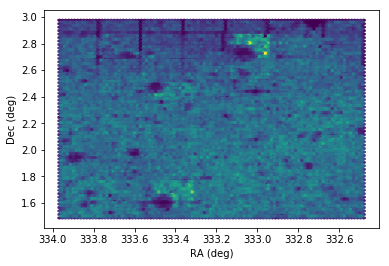

In [31]:
plt.figure()
plt.hexbin(np.degrees(df_coadd['coord_ra']), np.degrees(df_coadd['coord_dec']))
#plt.hexbin(df_coadd['base_SdssCentroid_x'], df_coadd['base_SdssCentroid_y'])
plt.xlim(plt.xlim()[::-1])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

## Part 3: Characterization

Show a few examples of how to characterize shape measurements.

### Ellipticity residuals for PSF calibration stars and reserve stars


In [32]:
def ellipticity(i_xx, i_yy, i_xy):
    e1 = (i_xx - i_yy) / (i_xx + i_yy)
    e2 = (2. * i_xy) / (i_xx + i_yy)
    return e1, e2

In [33]:
# Ellipticity residuals
e1_star, e2_star = ellipticity(df_coadd['slot_Shape_xx'], df_coadd['slot_Shape_yy'], df_coadd['slot_Shape_xy'])
e1_psf, e2_psf = ellipticity(df_coadd['slot_PsfShape_xx'], df_coadd['slot_PsfShape_yy'], df_coadd['slot_PsfShape_xy'])
e1_res, e2_res = e1_star - e1_psf, e2_star - e2_psf 

In [34]:
"""
# Plot to inform S/N selection
plt.figure()
plt.scatter(df_coadd['psf_mag'], df_coadd['psf_mag'] - df_coadd['cm_mag'], 
            c=df_coadd['slot_PsfFlux_flux'] / df_coadd['slot_PsfFlux_fluxSigma'], 
            vmin=1, vmax=100, s=1)
plt.colorbar()
plt.xlim(16., 30.)
plt.ylim(-0.1, 1.)
"""

"\n# Plot to inform S/N selection\nplt.figure()\nplt.scatter(df_coadd['psf_mag'], df_coadd['psf_mag'] - df_coadd['cm_mag'], \n            c=df_coadd['slot_PsfFlux_flux'] / df_coadd['slot_PsfFlux_fluxSigma'], \n            vmin=1, vmax=100, s=1)\nplt.colorbar()\nplt.xlim(16., 30.)\nplt.ylim(-0.1, 1.)\n"

Text(0,0.5,'PDF')

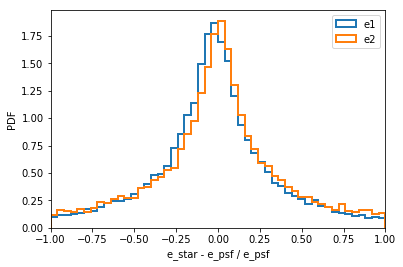

In [35]:
cut_star = ((df_coadd['slot_PsfFlux_flux'] / df_coadd['slot_PsfFlux_fluxSigma']) > 100.) & (df_coadd['base_ClassificationExtendedness_value'] == 0)

plt.figure()
#plt.yscale('log')
plt.hist(e1_res[cut_star] / e1_psf[cut_star], bins=np.linspace(-1., 1., 51), range=(-1., 1.), histtype='step', lw=2, density=True, label='e1')
plt.hist(e2_res[cut_star] / e2_psf[cut_star], bins=np.linspace(-1., 1., 51), range=(-1., 1.), histtype='step', lw=2, density=True, label='e2')
plt.xlim(-1., 1.)
plt.legend(loc='upper right')
plt.xlabel('e_star - e_psf / e_psf')
plt.ylabel('PDF')

Repeat the exercise with the single-sensor, but compare the stars used for PSF modeling and those held in reserve for testing. In this case, there are only ~100 stars total on the single sensor so not enough statistics to see any more interesting trends. In practice, one would want to do this test with many more stars.

In [36]:
# Ellipticity residuals
e1_star, e2_star = ellipticity(src['slot_Shape_xx'], src['slot_Shape_yy'], src['slot_Shape_xy'])
e1_psf, e2_psf = ellipticity(src['slot_PsfShape_xx'], src['slot_PsfShape_yy'], src['slot_PsfShape_xy'])
e1_res, e2_res = e1_star - e1_psf, e2_star - e2_psf 

Number of stars used for PSF modeling = 89
Number of reserved stars = 23


Text(0,0.5,'PDF')

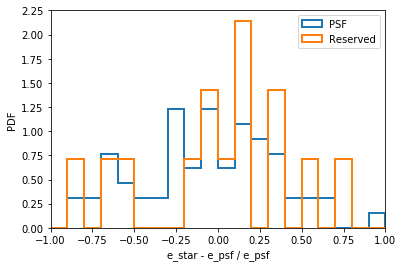

In [37]:
cut_psf_star = src['calib_psfUsed']
cut_reserved_star = src['calib_psf_reserved']

print('Number of stars used for PSF modeling =', np.sum(cut_psf_star))
print('Number of reserved stars =', np.sum(cut_reserved_star)) # Should be about 20% of the sample used for PSF modeling

plt.figure()
#plt.yscale('log')
plt.hist(e1_res[cut_psf_star] / e1_psf[cut_psf_star], bins=np.linspace(-1., 1., 21), range=(-1., 1.), histtype='step', lw=2, density=True, label='PSF')
plt.hist(e1_res[cut_reserved_star] / e1_psf[cut_reserved_star], bins=np.linspace(-1., 1., 21), range=(-1., 1.), histtype='step', lw=2, density=True, label='Reserved')
plt.xlim(-1., 1.)
plt.legend(loc='upper right')
plt.xlabel('e_star - e_psf / e_psf')
plt.ylabel('PDF')

### Compute aggregate statistics across the focal plane / tract

This example shows how to use pandas to compute aggregate statistics across the focal plane. In this case, we plot the mean PSF model size (trace radius) computed in spatial bins over the sensor.

In [38]:
#Convert the src object to a pandas dataframe
df_sensor = src.asAstropy().to_pandas()

Define a helper function to aggregate statistics in two-dimensions.

In [39]:
def aggregateStatistics2D(df, x_name, x_bins, y_name, y_bins, z_name, operation):
    """
    This function preserves empty bins, which get filled by nan values
    """
    x_centers = x_bins[:-1] + 0.5 * np.diff(x_bins)
    y_centers = y_bins[:-1] + 0.5 * np.diff(y_bins)
    grouped = df.groupby([pd.cut(df[y_name], bins=y_bins),
                          pd.cut(df[x_name], bins=x_bins)])
    xx, yy = np.meshgrid(x_centers, y_centers)
    zz = grouped['id', z_name].agg(operation)[z_name].values.reshape(xx.shape)
    return xx, yy, zz

In [40]:
# Define a new column for the PSF model trace radius
df_sensor['psf_trace_radius'] =  np.sqrt((src['slot_PsfShape_xx'] + src['slot_PsfShape_yy']) / 2.)


The next plot should look the same as the plot above that shows the PSF model size evaluated in a grid across the sensor

(0, 4176)

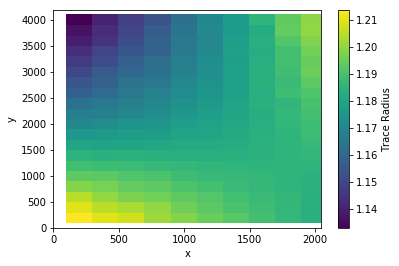

In [41]:
bin_size = 200 # pixels
x_bins = np.arange(0, calexp.getDimensions()[0] + bin_size, bin_size)
y_bins = np.arange(0, calexp.getDimensions()[1] + bin_size, bin_size)

xx, yy, zz = aggregateStatistics2D(df_sensor, 
                                   'slot_Centroid_x', x_bins, 
                                   'slot_Centroid_y', y_bins, 
                                   'psf_trace_radius', 'mean')

plt.figure()
plt.pcolormesh(xx, yy, zz)
plt.colorbar(label='Trace Radius')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, calexp.getDimensions()[0])
plt.ylim(0, calexp.getDimensions()[1])

Now repeat the aggregaion exercise for the coadd tract.

In [42]:
# Define a new column for the PSF model trace radius
df_coadd['psf_trace_radius'] =  np.sqrt((df_coadd['ext_shapeHSM_HsmPsfMoments_xx'] + df_coadd['ext_shapeHSM_HsmPsfMoments_yy']) / 2.)

(2059.2842544546083, 33942.28102108745)

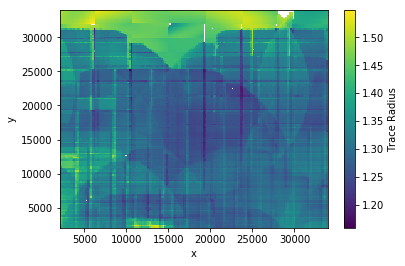

In [43]:
bin_size = 200 # pixels
x_bins = np.arange(np.min(df_coadd.base_SdssCentroid_x), np.max(df_coadd.base_SdssCentroid_x) + bin_size, bin_size)
y_bins = np.arange(np.min(df_coadd.base_SdssCentroid_y), np.max(df_coadd.base_SdssCentroid_y) + bin_size, bin_size)

xx, yy, zz = aggregateStatistics2D(df_coadd, 
                                   'base_SdssCentroid_x', x_bins, 
                                   'base_SdssCentroid_y', y_bins, 
                                   'psf_trace_radius', 'mean')

plt.figure()
plt.pcolormesh(xx, yy, zz)
plt.colorbar(label='Trace Radius')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(np.min(df_coadd.base_SdssCentroid_x), np.max(df_coadd.base_SdssCentroid_x))
plt.ylim(np.min(df_coadd.base_SdssCentroid_y), np.max(df_coadd.base_SdssCentroid_y))

### Ellipticity residual correlation functions

Example of how to evaluate correlation functions, in this case, for ellipticity residuals on the coadd. This section reproduces the analysis of `validate_drp` (https://github.com/lsst/validate_drp) in a condensed form for easier reading.

In [44]:
import treecorr
import astropy.units as u

In [45]:
# Ellipticity residuals
e1_star, e2_star = ellipticity(df_coadd['slot_Shape_xx'], df_coadd['slot_Shape_yy'], df_coadd['slot_Shape_xy'])
e1_psf, e2_psf = ellipticity(df_coadd['slot_PsfShape_xx'], df_coadd['slot_PsfShape_yy'], df_coadd['slot_PsfShape_xy'])
e1_res, e2_res = e1_star - e1_psf, e2_star - e2_psf 

In [46]:
# Select high S/N stars
cut_star = ((df_coadd['slot_PsfFlux_flux'] / df_coadd['slot_PsfFlux_fluxSigma']) > 100.) & (df_coadd['base_ClassificationExtendedness_value'] == 0)
cut_star = cut_star & ~np.isnan(e1_res) & ~np.isnan(e2_res)

nbins=20
min_sep=0.25
max_sep=20
sep_units='arcmin'
verbose=False

catTree = treecorr.Catalog(ra=df_coadd['coord_ra'][cut_star], dec=df_coadd['coord_dec'][cut_star], 
                           g1=e1_res[cut_star], g2=e2_res[cut_star],
                           dec_units='radian', ra_units='radian')
gg = treecorr.GGCorrelation(nbins=nbins, min_sep=min_sep, max_sep=max_sep,
                            sep_units=sep_units,
                            verbose=verbose)
gg.process(catTree)
r = np.exp(gg.meanlogr) * u.arcmin
xip = gg.xip * u.Unit('')
xip_err = np.sqrt(gg.varxi) * u.Unit('')

Text(0,0.5,'Median Residual Ellipticity Correlation')

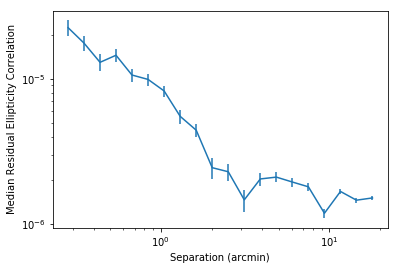

In [47]:
plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.errorbar(r.value, xip, yerr=xip_err)
plt.xlabel('Separation (arcmin)')
plt.ylabel('Median Residual Ellipticity Correlation')